In [1]:
# 导入需要的模块
import tensorflow as tf # tensorflow模块，深度学习框架
import keras # keras模块，深度学习框架
import re # 正则表达式
import numpy as np # numpy数组
import pandas as pd # pandas表格
import matplotlib.pyplot as plt # matplotlib 数据可视化
from PIL import Image # 读取图片
from tqdm import tqdm # 显示循环进度条
from sklearn.model_selection import train_test_split # 训练集、验证集、测试集的划分
from itertools import product # 迭代工具
from tensorflow.keras.models import load_model # 用于加载模型
from sklearn.utils import class_weight # 用于计算样本的权重
from sklearn.metrics import roc_curve, auc # 用于绘画ROC曲线，计算AUC值
from keras.preprocessing.image import ImageDataGenerator # keras模块的图片预处理模块，可用于数据增强
from keras.optimizers import Adam # Adam优化器
from collections import Counter # 词频统计包
import time
from keras.callbacks import TensorBoard
from keras.utils import multi_gpu_model
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import pandas as pd
train_data = pd.read_csv('train_data.csv',encoding='ISO-8859-1')
test_data = pd.read_csv('test_data.csv',encoding='ISO-8859-1')
train_data['non_toxic'] = train_data['toxic'].apply(lambda x:1 if x==0 else 0)
test_data['non_toxic'] = test_data['toxic'].apply(lambda x:1 if x==0 else 0)
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,168ac3d396c7d588,if there is a chromosone then e=what is it?Sma...,0,0,0,0,0,0,1
1,168bc99fa2cfd9aa,Hollywood Undead \n\nI have collected articles...,0,0,0,0,0,0,1
2,168cd51c24508159,"""\n\n Rollback \n\nI've enabled rollback on yo...",0,0,0,0,0,0,1
3,168d515e2e99f78d,Another backlog. Thanks. (Trouble?/My Work),0,0,0,0,0,0,1
4,168d5a1c66f5e8bf,""" - unsigned\n\nWe do include it. This article...",0,0,0,0,0,0,1


In [4]:
form_dict={'severe_toxic':1,'obscene':2,'threat':3,'insult':4,'identity_hate':5,'non_toxic':0}

tmp_traindata = train_data[['severe_toxic','obscene','threat','insult','identity_hate','non_toxic']]
train_data['Form'] = tmp_traindata.apply(lambda row:form_dict[tmp_traindata.columns[row.tolist().index(max(row.tolist()))]] , axis = 1 )

tmp_testdata = test_data[['severe_toxic','obscene','threat','insult','identity_hate','non_toxic']]
test_data['Form'] = tmp_testdata.apply(lambda row:form_dict[tmp_testdata.columns[row.tolist().index(max(row.tolist()))]] , axis = 1 )

In [5]:
train_data['Form'].value_counts()

0    193488
2      9212
1      8116
4      2106
5       249
3       205
Name: Form, dtype: int64

In [6]:
# 处理训练集
# 将对应的标签拿出来
#train_labels = np.array(train_data['Form'], dtype=np.int32)
train_labels = to_categorical(train_data['Form'])
t0 = time.time()
# 分词处理
train_intro_texts = []
for intro in train_data['comment_text']:
    intro = intro.replace(',',' ').replace('.',' ').replace('\n',' ').replace('?',' ').replace('!',' ').replace(';',' ').replace(':',' ')
    intro = intro.replace('(',' ').replace(')',' ').replace('[',' ').replace(']',' ').replace('{',' ').replace('}',' ')
    intro = intro.replace('"',' ').replace('."',' ').replace('?"',' ').replace('!"',' ').replace('-','')
    intro = intro.lower()
    intro = [i for i in intro.split()]
    train_intro_texts.append(intro)
print("分词时间：%s"%(time.time()-t0))

分词时间：3.672091007232666


In [7]:
# 处理测试集
# 将对应的标签拿出来
#test_labels = np.array(test_data['Form'], dtype=np.int32)
test_labels = to_categorical(test_data['Form'])
t0 = time.time()
# 分词处理
test_intro_texts = []
for intro in test_data['comment_text']:
    intro = intro.replace(',',' ').replace('.',' ').replace('\n',' ').replace('?',' ').replace('!',' ').replace(';',' ').replace(':',' ')
    intro = intro.replace('(',' ').replace(')',' ').replace('[',' ').replace(']',' ').replace('{',' ').replace('}',' ')
    intro = intro.replace('"',' ').replace('."',' ').replace('?"',' ').replace('!"',' ').replace('-','')
    intro = intro.lower()
    intro = [i for i in intro.split()]
    test_intro_texts.append(intro)
print("分词时间：%s"%(time.time()-t0))

分词时间：0.17212510108947754


In [8]:
# 训练集，验证集，测试集的划分
# text_s,text_test_s,\
# label_s,label_test_s = train_test_split(
#     intro_texts,labels,
#     test_size=1.0, 
#     stratify=labels,
#     random_state=233)
text_train,text_val,\
label_train,label_val = train_test_split(
    train_intro_texts,train_labels,
    test_size=0.2, 
    stratify=train_labels,
    random_state=233)  # 训练集和验证集的划分
text_test = test_intro_texts
label_test = test_labels
print(text_train[0])
print(label_train[0])
print(len(text_train))
print(len(label_train))

['statto', 'com', 'hello', 'yes', "it's", 'been', 'back', 'for', 'a', 'couple', 'of', 'weeks', 'now', 'hopefully', 'it', 'intends', 'to', 'stay', 'up', 'this', 'time', 'cheers']
[1. 0. 0. 0. 0. 0.]
170700
170700


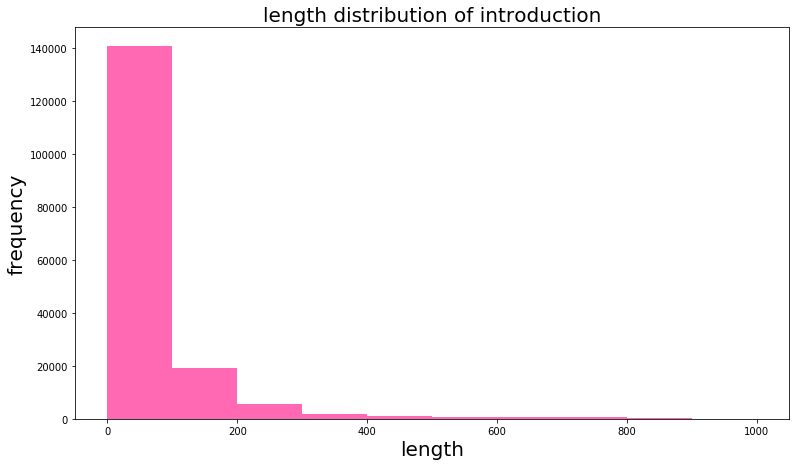

In [9]:
intro_lengths = [len(introduction) for introduction in text_train]#统计评论的长度

#绘制长度的直方图
fig,axe = plt.subplots(figsize=(12.8,7.2))
axe.hist(intro_lengths,bins=[0,100,200,300,400,500,600,700,800,900,1000],color="hotpink")
axe.set_title("length distribution of introduction",fontsize=20)
axe.set_xlabel("length",fontsize=20)
axe.set_ylabel("frequency",fontsize=20)
plt.show()

SENLEN = 400

# VOCAB_SIZE 的决定:训练集上该词出现的次数>=2
train_word_list = [word for sequence in text_train for word in sequence]
word_counter_introduction = Counter(train_word_list)#统计每个词出现的次数
most_common_word_in_train_introduction = word_counter_introduction.most_common()#词频降序排序
VOCAB_SIZE = len(most_common_word_in_train_introduction) + 1 # 设置一个初值，大概率结果不是这个
for i in range(len(most_common_word_in_train_introduction)):
    if most_common_word_in_train_introduction[i][1] <= 1:
        VOCAB_SIZE = i + 1 #VOCAB_SIZE设为词频>=2的词的数量
        break
        
# 对训练集建表
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text_train)

# 将训练集的文本数字化
text_train = tokenizer.texts_to_sequences(text_train)
text_train = keras.preprocessing.sequence.pad_sequences(
    text_train, maxlen=SENLEN, padding='post')

# 将验证集的文本数字化
text_val = tokenizer.texts_to_sequences(text_val)
text_val = keras.preprocessing.sequence.pad_sequences(
    text_val, maxlen=SENLEN, padding='post')

# 将测试集的文本数字化
text_test = tokenizer.texts_to_sequences(text_test)
text_test = keras.preprocessing.sequence.pad_sequences(
    text_test, maxlen=SENLEN, padding='post')

### 尝试随机过采样

In [10]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(text_train,label_train)
print(len(X_resampled))
#print(sorted(Counter(y_resampled).items()))
print(len(text_train))

928740
170700


## Bi-LSTM 测试

In [11]:
'''
model : Bi-LSTM
'''
EMBED_SIZE = 128

# Bi-LSTM
inp_text = keras.layers.Input(shape=(SENLEN,)) #输入，长度为SENLEN
embed = keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=SENLEN,mask_zero=True)(inp_text) #词嵌入层
x = keras.layers.Bidirectional(keras.layers.LSTM(EMBED_SIZE))(embed)# Bi-LSTM
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
preds=keras.layers.Dense(6,activation='sigmoid')(x) #预测层：二分类
model2=keras.Model(inputs=inp_text,outputs=preds)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 128)          14036608  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
__________

In [14]:
model2.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early2_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model2.fit(X_resampled, y_resampled,
    validation_data=[text_val,label_val],
    epochs=3,
    batch_size=512,
    callbacks=[early2_stopping],
    #class_weight=class_weight,
    shuffle=True)
#model2.save('model2.h5')

Train on 928740 samples, validate on 42676 samples
Epoch 1/3
928740/928740 [==============================] - 1967s 2ms/step - loss: 0.2587 - acc: 0.8952 - val_loss: 0.1106 - val_acc: 0.9630
Epoch 2/3
928740/928740 [==============================] - 1996s 2ms/step - loss: 0.0828 - acc: 0.9663 - val_loss: 0.1472 - val_acc: 0.9601
Epoch 3/3
928740/928740 [==============================] - 1982s 2ms/step - loss: 0.0483 - acc: 0.9825 - val_loss: 0.1677 - val_acc: 0.9648


In [15]:
encoder = LabelEncoder()
# make predictions
pred = model2.predict(text_test)
#pred = encoder.fit_transform(pred)
# inverse numeric variables to initial categorical labels
pred_labels = [np.argmax(x) for x in pred]

In [16]:
cf = confusion_matrix(test_data['Form'],pred_labels)
cf

array([[7249,  236,   66,    9,   28,    5],
       [ 406,  406,  327,   13,   61,    9],
       [  81,  263,  659,    4,   41,    0],
       [   5,   11,    5,    4,    2,    1],
       [  58,   98,   58,    1,   40,    5],
       [   5,    5,    3,    2,    3,    4]])

In [18]:
print("Accuracy: %3f"%((TP+TN)/(TP+TN+FP+FN)))
print("Precision: %3f"%(TP/(TP+FP)))
print("Recall: %3f"%((TP)/(TP+FN)))
print("Specificity: %3f"%((TN)/(TN+FP)))
precision = TP/(TP+FP)
recall = (TP)/(TP+FN)
F1Score = 2*recall*precision/(recall+precision)
print("F1-Score: %3f"%F1Score)

Accuracy: 0.911629
Precision: 0.928883
Recall: 0.954695
Specificity: 0.784884
F1-Score: 0.941612
